In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


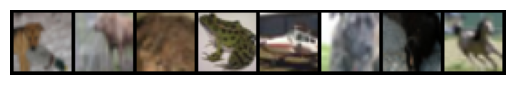

Training: 100%|██████████| 782/782 [00:32<00:00, 24.00it/s]


Epoch 1/10, Loss: 8374.0124, Accuracy: 0.0022


Training: 100%|██████████| 782/782 [00:28<00:00, 27.32it/s]


Epoch 2/10, Loss: 8374.0124, Accuracy: 0.0004


Training: 100%|██████████| 782/782 [00:27<00:00, 27.98it/s]


Epoch 3/10, Loss: 8374.0124, Accuracy: 0.0003


Training: 100%|██████████| 782/782 [00:28<00:00, 27.90it/s]


Epoch 4/10, Loss: 8374.0124, Accuracy: 0.0074


Training: 100%|██████████| 782/782 [00:27<00:00, 28.08it/s]


Epoch 5/10, Loss: 8374.0124, Accuracy: 0.0001


Training: 100%|██████████| 782/782 [00:28<00:00, 27.60it/s]


Epoch 6/10, Loss: 8374.0124, Accuracy: 0.0032


Training: 100%|██████████| 782/782 [00:28<00:00, 27.68it/s]


Epoch 7/10, Loss: 8374.0124, Accuracy: 0.0152


Training: 100%|██████████| 782/782 [00:27<00:00, 27.98it/s]


Epoch 8/10, Loss: 8374.0124, Accuracy: 0.0156


Training: 100%|██████████| 782/782 [00:28<00:00, 27.80it/s]


Epoch 9/10, Loss: 8374.0124, Accuracy: 0.0156


Training: 100%|██████████| 782/782 [00:27<00:00, 28.02it/s]


Epoch 10/10, Loss: 8374.0124, Accuracy: 0.0157


In [39]:
class SimCLRModel(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super(SimCLRModel, self).__init__()

        # Remove the final fully connected layer from the base encoder
        self.encoder = nn.Sequential(*list(base_encoder.children())[:-1])

        # Add projection head
        self.projector = nn.Sequential(
            nn.Linear(base_encoder.fc.in_features, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0), -1)

        # Project the features using the projection head
        projections = self.projector(features)

        normalized_projections = torch.nn.functional.normalize(projections, dim=1)
        return features, normalized_projections, projections




class SimCLRLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(SimCLRLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        # Normalize projections
        z1_normalized = torch.nn.functional.normalize(z1, dim=1)
        z2_normalized = torch.nn.functional.normalize(z2, dim=1)

        # Calculate cosine similarity
        similarities = torch.nn.functional.cosine_similarity(z1_normalized, z2_normalized) / self.temperature

        # Create labels (positive samples are along the diagonal)
        labels = torch.arange(len(similarities)).to(z1.device).long()  # Ensure labels are of type LongTensor

        # Convert labels to float type
        labels = labels.float()

        # Compute loss
        loss = nn.CrossEntropyLoss()(similarities, labels)
        return loss


def train_simclr(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, _ in tqdm(dataloader, desc="Training"):
        images = images.to(device)

        # Forward pass
        features, projections, normalized_projections = model(images)

        # SimCLR loss
        loss = criterion(normalized_projections, normalized_projections)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy using normalized projections
        _, predicted_labels = torch.max(normalized_projections, 1)
        total_samples += images.size(0)
        correct_predictions += (predicted_labels == torch.arange(images.size(0)).to(device)).sum().item()

    accuracy = correct_predictions / total_samples
    return total_loss / len(dataloader), accuracy


def visualize_augmentations(dataloader):
    images, _ = next(iter(dataloader))
    grid_image = make_grid(images[:8], nrow=8, padding=2, normalize=True)
    plt.imshow(grid_image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()




def main():
    batch_size = 64
    projection_dim = 128
    learning_rate = 1e-3
    epochs = 10

    # Initialize SimCLR model with ResNet18 backbone
    base_encoder = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
    model = SimCLRModel(base_encoder, projection_dim)

    # Load CIFAR-10 dataset
    transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    # Visualize augmentations
    visualize_augmentations(train_dataloader)

    # Initialize SimCLR loss and optimizer
    criterion = SimCLRLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train SimCLR model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    writer = SummaryWriter()

    for epoch in range(epochs):
        train_loss, accuracy = train_simclr(model, train_dataloader, criterion, optimizer, device)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Save the model
    torch.save(model.state_dict(), 'simclr_model.pth')

if __name__ == "__main__":
    main()


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define Vanilla CNN for Classification
class VanillaCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(VanillaCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Training function for Vanilla CNN
def train_vanilla_cnn(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Evaluate function for any model
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Main Experiment
def main_experiment():
    # Set hyperparameters
    batch_size = 64
    learning_rate = 1e-3
    epochs = 10

    # Load CIFAR-10 dataset
    transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Initialize Vanilla CNN and train
    vanilla_cnn = VanillaCNN(num_classes=10)
    vanilla_cnn.to('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(vanilla_cnn.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        train_loss = train_vanilla_cnn(vanilla_cnn, train_dataloader, criterion, optimizer, 'cuda')
        print(f"Epoch {epoch + 1}/{epochs}, Vanilla CNN Loss: {train_loss:.4f}")

    # Initialize SimCLR model and train
    # (Assuming you have already implemented and trained the SimCLR model)

    # Evaluate both models on the test set
    accuracy_vanilla_cnn = evaluate_model(vanilla_cnn, test_dataloader, 'cuda')
    # accuracy_simclr = evaluate_model(simclr_model, test_dataloader, 'cuda')  # Uncomment when you have SimCLR model

    print(f"Vanilla CNN Accuracy: {accuracy_vanilla_cnn}")
    # print(f"SimCLR Accuracy: {accuracy_simclr}")

if __name__ == "__main__":
    main_experiment()


Files already downloaded and verified
Files already downloaded and verified


Training: 100%|██████████| 782/782 [00:20<00:00, 37.91it/s]


Epoch 1/10, Vanilla CNN Loss: 1.7762


Training: 100%|██████████| 782/782 [00:19<00:00, 40.17it/s]


Epoch 2/10, Vanilla CNN Loss: 1.5512


Training: 100%|██████████| 782/782 [00:20<00:00, 37.75it/s]


Epoch 3/10, Vanilla CNN Loss: 1.4465


Training: 100%|██████████| 782/782 [00:20<00:00, 39.02it/s]


Epoch 4/10, Vanilla CNN Loss: 1.3771


Training: 100%|██████████| 782/782 [00:20<00:00, 39.00it/s]


Epoch 5/10, Vanilla CNN Loss: 1.3261


Training: 100%|██████████| 782/782 [00:20<00:00, 37.77it/s]


Epoch 6/10, Vanilla CNN Loss: 1.2795


Training: 100%|██████████| 782/782 [00:19<00:00, 39.63it/s]


Epoch 7/10, Vanilla CNN Loss: 1.2465


Training: 100%|██████████| 782/782 [00:21<00:00, 36.48it/s]


Epoch 8/10, Vanilla CNN Loss: 1.2206


Training: 100%|██████████| 782/782 [00:28<00:00, 27.03it/s]


Epoch 9/10, Vanilla CNN Loss: 1.2017


Training: 100%|██████████| 782/782 [00:29<00:00, 26.10it/s]

Epoch 10/10, Vanilla CNN Loss: 1.1829


Vanilla CNN Accuracy: 0.5753
